# Apple Identification - Image Recognition Project

![apples](./data/Images/apples_red_green.jpeg/)

## Overview / Business Problem

The stakeholder is Mott’s, a nationally recognized fruit supplier and produced. Mott’s which operates under license by C.H. Robinson, an even larger, global supplier of fresh fruit and vegetables. While Mott’s offers several variations of fruit products, a vast majority of their goods rely solely on apples. With companies off Mott’s size, production factories will typically process hundreds of thousands of fruits daily. At present, Mott’s and other fruit/vegetable suppliers rely on farmers to deliver goods organized by variety or type of apple, for example. However, with hectic harvests and tight delivery/shipping deadlines, it is common for organization of goods to suffer. As such, Mott’s seeks a model that will aid workers with effectively categorizing apples to ensure the fruit will be correctly distributed to products. This project will provide Mott’s with a model which utilizes neural network image recognition in order to be able to visually recognize an apple’s variety. By implementing this model, Mott’s will be able to efficiently recognize apples being processed and efficiently streamline its organization process.

## Data Understanding

**[The data](https://www.kaggle.com/datasets/moltean/fruits)** set comes from Kaggle, a data sharing site. The data was originally contained 24 different fruit and vegetable varieties, totaling at about 103,000 images. However, this model only includes an analysis of apples and as such contained ~3,800 photos total. The data set’s images were organized into three separate folders, a train, a test, and a validation folder. Approximately 65% of the photos were found in the train folder, about 25% of the photos were in the test folder, and the remaining 10% were found in the validation folder. Each variety of apple contained a range of between 600 and 650 for each apple variety. The apple varieties included are Braeburn Crimson Snow, Golden Delicious, Granny Smith, Pink Lady, and Red Delicious.

### Import Necessary Libraries

In [7]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import itertools
import random
import PIL
from PIL import Image
import io

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, \
GlobalAveragePooling2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras import models, layers 
from keras_preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import  Adam

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix

### Load the Files of Images

Here we will inspect the data by loading the file paths. We have two separate file paths, one with data augmented images and one with no data augmented images. The augmented images were created further down in the notebook and will be covered in more detail.

In [8]:
#Create variables for the each train, test, and validation folders for the augmented and non-augmented data/images
no_aug_train_path =  './data/fruits-360_dataset/fruits-360_2/Training'
no_aug_test_path = './data/fruits-360_dataset/fruits-360_2/Test'
no_aug_val_path = './data/fruits-360_dataset/fruits-360_2/Validation'

aug_train_path =  './data/fruits-360_dataset/fruits-360/Training'
aug_test_path = './data/fruits-360_dataset/fruits-360/Test'
aug_val_path = './data/fruits-360_dataset/fruits-360/Validation'

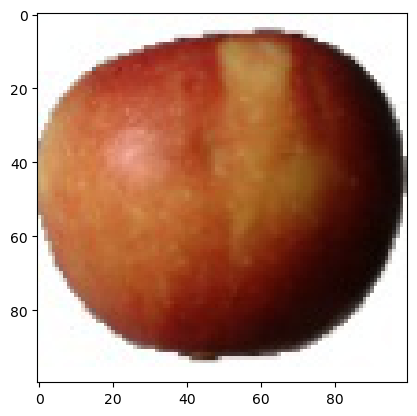

In [9]:
#Create a random image variable, in this case we will select a random Braeburn apple image with no data augmentation
chosen_image = random.choice(os.listdir('./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/'))
image_path = './data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

## Modeling

As previously mentioned, the data set includes six different apple varieties – Braeburn (red), Crimson Snow (red), Golden Delicious (green), Granny Smith (green), Pink Lady (red), and Red Delicious (red). To effectively analyze these images, we will utilize a neural network model and tune parameters to maximize accuracy scores and minimize loss. Throughout this project, we will utilize variations of a Sequential model and Image Data Generators. In aggregate, there were three models (including the baseline) that were ran. The second and third model were each ran with the augmented and non-augmented data sets to show the differences between the two. Ultimately the final model with the augmented images was selected as the ‘final’ model, which will be covered in more detail below.

### Baseline Model

To begin, we will utilize a simple Sequential neural-network model with one Dense layer. For this model, we will also use the data set in its original form, with no augmented images.

In [10]:
#Instansiate an ImageDataGenerator
datagen = ImageDataGenerator()

In [11]:
#Apply an ImageDataGenerator for each file type, the train, test, and validation images
baseline_train_datagen = ImageDataGenerator(rescale = 1./255)
baseline_test_datagen = ImageDataGenerator(rescale = 1./255)
baseline_val_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
#Set the image size to 100x100, this is the current size of all images in the data set
baseline_image_size = (100, 100)

#Create a generator for each of the train, test, and validation files
    #We will utilize the original data set with no augmented images, set the path to the no_aug applicable path
    #Set the batch size to the number of images in the applicable folder
    #The color mode of these images are RGB
    #The class mode is categorical as there are >2 apple types being reviewed
    #Set the random seed consistently to 42
baseline_train_generator = baseline_train_datagen.flow_from_directory(
    no_aug_train_path,
    target_size = baseline_image_size,
    batch_size = 2563,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

#Repeat the same steps here with the applicable file path and batch size
baseline_test_generator = baseline_test_datagen.flow_from_directory(
    no_aug_test_path,
    target_size = baseline_image_size,
    batch_size = 954,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

#Repeat the same steps here with the applicable file path and batch size
baseline_val_generator = baseline_val_datagen.flow_from_directory(
    no_aug_val_path,
    target_size = baseline_image_size,
    batch_size = 285,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

Found 2563 images belonging to 6 classes.
Found 954 images belonging to 6 classes.
Found 285 images belonging to 6 classes.


In [13]:
#Create a list of the class names, this should match the apple varieties being reviewed
train_class_names = list(baseline_train_generator.class_indices.keys())
train_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [14]:
#Create the data sets for each of the train, test and validation images
baseline_train_images, baseline_train_labels = next(baseline_train_generator)
baseline_test_images, baseline_test_labels = next(baseline_test_generator)
baseline_val_images, baseline_val_labels = next(baseline_val_generator)

#Reshape the X or _images variables such that this reshaped variable will run through the model with no errors
baseline_train_img = baseline_train_images.reshape(baseline_train_images.shape[0], -1)
baseline_test_img = baseline_test_images.reshape(baseline_test_images.shape[0], -1)
baseline_val_img = baseline_val_images.reshape(baseline_val_images.shape[0], -1)

In [15]:
#Create an opt variable which is set to the learning rate to be used, we will start with 0.0002
opt = Adam(learning_rate=0.0002)

#Instantiate a Sequential model
    #To start, add one Dense layer, set the layer to 6 as there are 6 apple varieties
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(6))

#Set the random seed to 3 for reproducibility
np.random.seed(3)

#Compile the model and utilize the 'opt' variable, utilize the categorical crossentropy for loss as this is not a
    #binary model, and utilize 'accuracy' as the target metric
baseline_model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

#Creat a new _histoire variable containing the fit model
    #To begin, we will utilize 25 epochs and a batch size of 80
baseline_model_histoire = baseline_model.fit(baseline_train_img,
                                       baseline_train_labels,
                                       epochs = 25,
                                       batch_size = 80,
                                       validation_data = (baseline_val_img, baseline_val_labels))

Epoch 1/25


2022-12-12 00:06:45.575095: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 00:06:45.703933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 12ms/step - loss: 9.3800 - accuracy: 0.1756 - val_loss: 10.5757 - val_accuracy: 0.1684
Epoch 2/25
16/33 [=============>................] - ETA: 0s - loss: 10.4642 - accuracy: 0.1719

2022-12-12 00:06:46.159629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 8ms/step - loss: 10.5840 - accuracy: 0.1686 - val_loss: 10.5757 - val_accuracy: 0.1684
Epoch 3/25
33/33 [==============================] - 0s 8ms/step - loss: 10.5840 - accuracy: 0.1686 - val_loss: 10.5757 - val_accuracy: 0.1684
Epoch 4/25
33/33 [==============================] - 0s 8ms/step - loss: 10.5840 - accuracy: 0.1686 - val_loss: 10.5757 - val_accuracy: 0.1684
Epoch 5/25
33/33 [==============================] - 0s 8ms/step - loss: 10.5840 - accuracy: 0.1686 - val_loss: 10.5757 - val_accuracy: 0.1684
Epoch 6/25
33/33 [==============================] - 0s 7ms/step - loss: 10.5840 - accuracy: 0.1686 - val_loss: 10.5757 - val_accuracy: 0.1684
Epoch 7/25
33/33 [==============================] - 0s 8ms/step - loss: 10.5840 - accuracy: 0.1686 - val_loss: 10.5757 - val_accuracy: 0.1684
Epoch 8/25
33/33 [==============================] - 0s 8ms/step - loss: 10.5840 - accuracy: 0.1686 - val_loss: 10.5757 - val_accuracy: 0.1684
Epoch 9/25
33/33 

In [16]:
#View the model's total number of parameters using the .summary() function
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 180006    
                                                                 
Total params: 180,006
Trainable params: 180,006
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Create variables for the train and test results to print the accuracy and loss scores
baseline_model_results_train = baseline_model.evaluate(baseline_train_img, baseline_train_labels)
baseline_model_results_test = baseline_model.evaluate(baseline_test_img, baseline_test_labels)

30/30 [==============================] - 0s 5ms/step - loss: 10.5764 - accuracy: 0.1677


For the sake of consistency, we will refer to the below saved scores as the scores to be referenced throughout the notebook. As seen, the baseline model utilizing one Dense layer and the non-augmented image data set performed fairly poorly with a train accuracy and loss of ~33% and 11, respectively, and a test accuracy and loss of ~32% and 10, respectively.

In [18]:
#Below is a save function to continue to refer to specific scores achieved by this model
    #The save function is commented out in order to not contiously save the model when the notebook is ran

# baseline_model.save('./Supplement Notebooks/Saved Models/Baseline Model', save_format='tf')
baseline_model_saved = models.load_model('./Supplement Notebooks/Saved Models/Baseline Model')
baseline_model_saved.evaluate(baseline_train_img, baseline_train_labels)
baseline_model_saved.evaluate(baseline_test_img, baseline_test_labels)

23/81 [=======>......................] - ETA: 0s - loss: 10.4680 - accuracy: 0.3125

2022-12-12 00:06:53.101836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 6ms/step - loss: 9.9682 - accuracy: 0.3229


[9.96821403503418, 0.32285118103027344]

### Baseline Model Visualizations

#### Graphing Accuracy and Loss Metrics

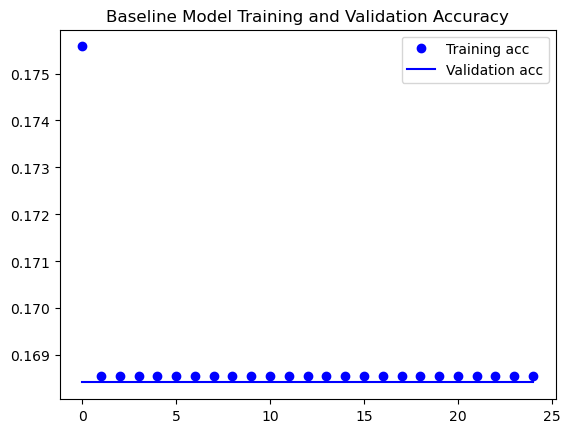

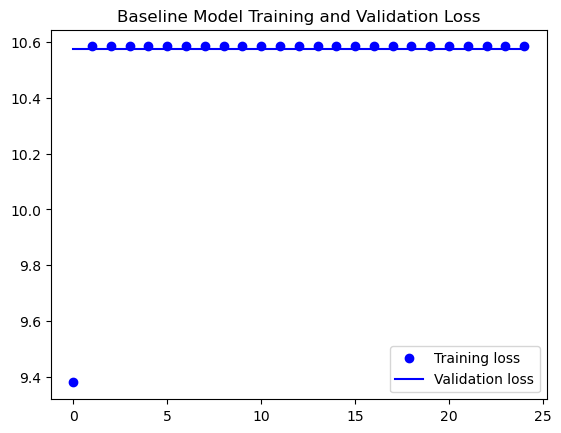

In [19]:
#Plot the model's train accuracy, validation accuracy, train loss, and validation loss by each epoch using the model's
    #histoire variable
baseline_model_acc = baseline_model_histoire.history['accuracy']
baseline_model_val_acc = baseline_model_histoire.history['val_accuracy']
baseline_model_loss = baseline_model_histoire.history['loss']
baseline_model_val_loss = baseline_model_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_acc))

plt.plot(baseline_model_epochs, baseline_model_acc, 'bo', label = 'Training acc')
plt.plot(baseline_model_epochs, baseline_model_val_acc, 'b', label = 'Validation acc')
plt.title('Baseline Model Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.show();



## Second Model

#### Augment Images

As previously mentioned, each variety of apple in the data set contains a range of between 600 and 650 images. Typically, within neural networks, it is encouraged that there is as much image data for each classification for the model to train on as much data as possible. Specifically with image processing, often within the ‘real world’ images are not for example, of fruit perfectly positioned on a table with a white background. Given that these are how most of the images are presented within this data set, we will utilize data augmentation in order to create other variations of the images available in order to increase our data set and therefor the trainability and accuracy of the model.

In [20]:
#Create a new ImageDataGenerator with parameters for the augmented images
    #For the parameters rescale the images, set the shear such that the image appears from different angles, apply a
    #zoom range and set it to 0.2, flip the image horizontally, rotate the image, and shift the image by width and
    #channel
aug_datagen = ImageDataGenerator(rescale = 1./255,
                                 shear_range = 0.2, 
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 rotation_range=10, 
                                 width_shift_range=0.1,  
                                 channel_shift_range=10.)

#Below is a function which will take in the apple variety's name, augment the images based on the ImageDataGenerator,
    #and save the augmented images into the applicable apple's folder
def augment_images(apple_name):
    names = [os.path.join(f'./data/fruits-360_dataset/fruits-360_2/Training/{apple_name}/', 
                          name) for name in os.listdir(f'./data/fruits-360_dataset/fruits-360_2/Training/{apple_name}/')]
    for f in names:
        if f.endswith('.jpg'):
            img = Image.open(f)
            x = img_to_array(img) 
            # Reshape the input image 
            x = x.reshape((1, ) + x.shape)  
            i = 0

            # generate 2 new augmented images 
            for batch in aug_datagen.flow(x, batch_size = 1, 
                              save_to_dir = f'./data/fruits-360_dataset/fruits-360/Training/{apple_name}',  
                              save_prefix = 'aug-image-', save_format ='jpg'):
                i += 1
                if i > 2: 
                    break

In [21]:
#The below code is commented out to avoid continously augmenting images and increasing the data set when re-running
#the notebook

# DO NOT RUN
# augment_images('Apple Braeburn')
# augment_images('Apple Crimson Snow')
# augment_images('Apple Golden')
# augment_images('Apple Granny Smith')
# augment_images('Apple Pink Lady')
# augment_images('Apple Red Delicious')

#### Second Model w/ Augmented Images

For this second model, we will utilize another Sequential model with this modeling adding more layers and complexity as well as utilizing the new data set with augmented images.

In [22]:
#Similar to the baseline model, use an ImageDataGenerator for each file type, the train, test, and validation images
model_2_train_datagen = ImageDataGenerator(rescale = 1./255)
model_2_test_datagen = ImageDataGenerator(rescale = 1./255)
model_2_val_datagen = ImageDataGenerator(rescale = 1./255)

#Set the image size to 100x100, this is the current size of all images in the data set
model_2_image_size = (100, 100)

#Create a generator for each of the train, test, and validation files
    #We will utilize the same parameters as the baseline model however for this second model we will
    #utilize the new data set with augmented images and update the batch sizes to reflect the new number of images
model_2_train_generator = model_2_train_datagen.flow_from_directory(
    aug_train_path,
    target_size = model_2_image_size,
    batch_size = 7841,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_2_test_generator = model_2_test_datagen.flow_from_directory(
    aug_test_path,
    target_size = model_2_image_size,
    batch_size = 3017,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_2_val_generator = model_2_val_datagen.flow_from_directory(
    aug_val_path,
    target_size = model_2_image_size,
    batch_size = 1207,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

Found 7841 images belonging to 6 classes.
Found 3017 images belonging to 6 classes.
Found 1207 images belonging to 6 classes.


In [23]:
#Create the data sets for each of the train, test and validation images
model_2_train_images, model_2_train_labels = next(model_2_train_generator)
model_2_test_images, model_2_test_labels = next(model_2_test_generator)
model_2_val_images, model_2_val_labels = next(model_2_val_generator)

#Reshape the X or _images variables such that this reshaped variable will run through the model with no errors
model_2_train_img = model_2_train_images.reshape(model_2_train_images.shape[0], -1)
model_2_test_img = model_2_test_images.reshape(model_2_test_images.shape[0], -1)
model_2_val_img = model_2_val_images.reshape(model_2_val_images.shape[0], -1)

In [24]:
#Instantiate a Sequential model
    #For this second model we will add four Dense layers and set the last layer to 6 as there are 6 apple varieties
    #Additionally, we will utilize 'relu' activations for the first 2 layers, 'tanh' activation for the third layer,
    #and 'softmax' activation for the last layer
model_2 = models.Sequential()
model_2.add(layers.Dense(6, activation = 'relu'))
model_2.add(layers.Dense(12, activation = 'relu'))
model_2.add(layers.Dense(48, activation = 'tanh'))
model_2.add(layers.Dense(6, activation = 'softmax'))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0001
opt = Adam(learning_rate=0.0001)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, utilize the categorical crossentropy for loss as this is not a
    #binary model, and utilize 'accuracy' as the target metric
model_2.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

#Creat a new _histoire variable containing the fit model
    #For this second model, we will utilize 50 epochs and a batch size of 100
model_2_histoire = model_2.fit(model_2_train_img,
                               model_2_train_labels,
                               epochs = 50,
                               batch_size = 100,
                               validation_data = (model_2_val_img, model_2_val_labels))

Epoch 1/50
 1/79 [..............................] - ETA: 22s - loss: 1.8173 - accuracy: 0.1100

2022-12-12 00:06:58.652495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 16ms/step - loss: 1.5221 - accuracy: 0.3566 - val_loss: 1.4628 - val_accuracy: 0.4333
Epoch 2/50


2022-12-12 00:06:59.843014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 13ms/step - loss: 1.2979 - accuracy: 0.4718 - val_loss: 1.3256 - val_accuracy: 0.4971
Epoch 3/50
79/79 [==============================] - 1s 12ms/step - loss: 1.1658 - accuracy: 0.5057 - val_loss: 1.2086 - val_accuracy: 0.5137
Epoch 4/50
79/79 [==============================] - 1s 13ms/step - loss: 1.0647 - accuracy: 0.5282 - val_loss: 1.1366 - val_accuracy: 0.5095
Epoch 5/50
79/79 [==============================] - 1s 13ms/step - loss: 0.9835 - accuracy: 0.5775 - val_loss: 1.0792 - val_accuracy: 0.5692
Epoch 6/50
79/79 [==============================] - 1s 12ms/step - loss: 0.9173 - accuracy: 0.6673 - val_loss: 1.0903 - val_accuracy: 0.6048
Epoch 7/50
79/79 [==============================] - 1s 12ms/step - loss: 0.8631 - accuracy: 0.7164 - val_loss: 1.0590 - val_accuracy: 0.6230
Epoch 8/50
79/79 [==============================] - 1s 13ms/step - loss: 0.8110 - accuracy: 0.7447 - val_loss: 0.9931 - val_accuracy: 0.6570
Epoch 9/50
79/79 [======

In [25]:
#View the model's total number of parameters using the .summary() function
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 180006    
                                                                 
 dense_4 (Dense)             (None, 12)                84        
                                                                 
 dense_5 (Dense)             (None, 48)                624       
                                                                 
 dense_6 (Dense)             (None, 6)                 294       
                                                                 
Total params: 181,008
Trainable params: 181,008
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Create variables for the train and test results to print the accuracy and loss scores
model_2_results_train = model_2.evaluate(model_2_train_img, model_2_train_labels)
model_2_results_test = model_2.evaluate(model_2_test_img, model_2_test_labels)

print(f'Model 2 Train Results: {model_2_results_train}')
print(f'Model 2 Test Results: {model_2_results_test}')

95/95 [==============================] - 1s 8ms/step - loss: 1.4401 - accuracy: 0.6725
Model 2 Train Results: [0.2230827957391739, 0.9155720472335815]
Model 2 Test Results: [1.4400831460952759, 0.6725223660469055]


Similar to the baseline model, for the sake of consistency, we will refer to the below saved scores as the scores to be referenced throughout the notebook. As seen, the second model utilizing more Dense layers and the augmented image data set performed better than the baseline model with a train accuracy and loss of ~95% and 0.2, respectively, and a test accuracy and loss of ~65% and 2, respectively.

In [27]:
# model_2.save('./Supplement Notebooks/Saved Models/Model 2', save_format='tf')
model_2_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 2')

model_2_saved.evaluate(model_2_train_img, model_2_train_labels)
model_2_saved.evaluate(model_2_test_img, model_2_test_labels)

 18/246 [=>............................] - ETA: 2s - loss: 0.1541 - accuracy: 0.9479

2022-12-12 00:07:53.357478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 8ms/step - loss: 1.9266 - accuracy: 0.6543


[1.9265921115875244, 0.6542923450469971]

#### Second Model w/ Augmented Images - Visualizations

#### Graphing Accuracy and Loss Metrics

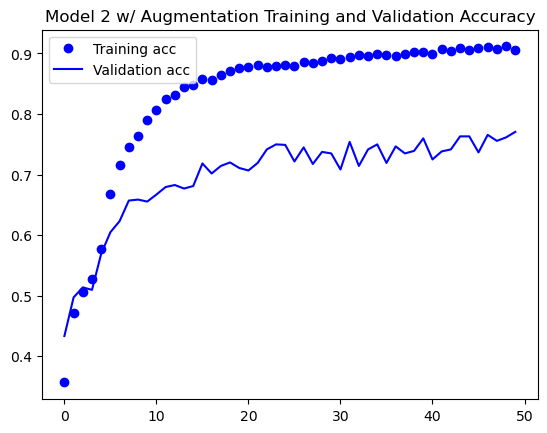

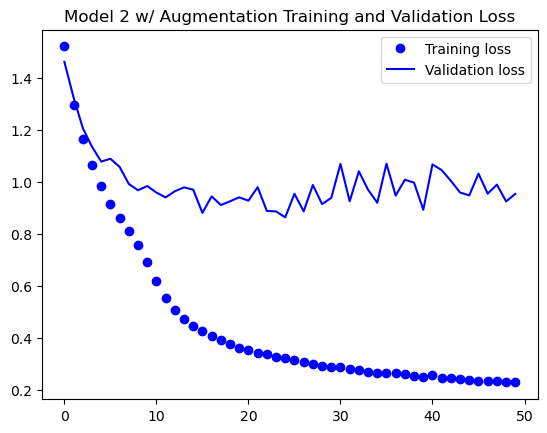

In [28]:
#Plot the model's train accuracy, validation accuracy, train loss, and validation loss by each epoch using the model's
    #histoire variable
model_2_acc = model_2_histoire.history['accuracy']
model_2_val_acc = model_2_histoire.history['val_accuracy']
model_2_loss = model_2_histoire.history['loss']
model_2_val_loss = model_2_histoire.history['val_loss']
model_2_epochs = range(len(model_2_acc))

plt.plot(model_2_epochs, model_2_acc, 'bo', label = 'Training acc')
plt.plot(model_2_epochs, model_2_val_acc, 'b', label = 'Validation acc')
plt.title('Model 2 w/ Augmentation Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(model_2_epochs, model_2_loss, 'bo', label = 'Training loss')
plt.plot(model_2_epochs, model_2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 w/ Augmentation Training and Validation Loss')
plt.legend()
plt.show();

#### Confusion Matrix

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
2022-12-12 00:07:56.610834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


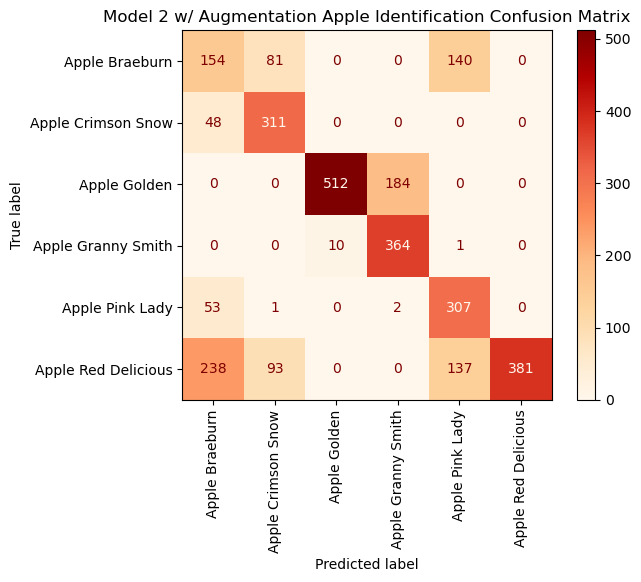

In [29]:
#For this model we will aslo create the confusion matrix

#Create a variable for the names of the apple varieties
class_names = train_class_names

#Create a function that takes inro account the model, an X variable, a y_true variable, and the display names
class estimator:
    _estimator_type = ''
    classes_= []
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob = self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)

        return y_pred
    
classifier = estimator(model_2, class_names)
plot_confusion_matrix(estimator = classifier, 
                      X = model_2_test_img, 
                      y_true = np.argmax(model_2_test_labels, axis = -1),
                      display_labels = class_names,
                      xticks_rotation = 'vertical',
                     cmap='OrRd');
plt.title('Model 2 w/ Augmentation Apple Identification Confusion Matrix')
plt.show()

#### Second Model w/ No Augmented Images

To compare with the other model, we will utilize the same parameters with a Sequential model except we will now demonstrate a model utilizing the original data set with no augmented images.

In [30]:
#Similar to the baseline model, use an ImageDataGenerator for each file type, the train, test, and validation images
no_aug_model_2_train_datagen = ImageDataGenerator(rescale = 1./255)
no_aug_model_2_test_datagen = ImageDataGenerator(rescale = 1./255)
no_aug_model_2_val_datagen = ImageDataGenerator(rescale = 1./255)

#Create a generator for each of the train, test, and validation files
    #We will utilize the original data set with no augmented images, set the path to the no_aug applicable path
    #Set the batch size to the number of images in the applicable folder
    #The color mode of these images are RGB
    #The class mode is categorical as there are >2 apple types being reviewed
    #Set the random seed consistently to 42
no_aug_model_2_train_generator = no_aug_model_2_train_datagen.flow_from_directory(
    no_aug_train_path,
    target_size = model_2_image_size,
    batch_size = 2563,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

no_aug_model_2_test_generator = no_aug_model_2_test_datagen.flow_from_directory(
    no_aug_test_path,
    target_size = model_2_image_size,
    batch_size = 954,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

no_aug_model_2_val_generator = no_aug_model_2_val_datagen.flow_from_directory(
    no_aug_val_path,
    target_size = model_2_image_size,
    batch_size = 285,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

#Create the data sets for each of the train, test and validation images
no_aug_model_2_train_images, no_aug_model_2_train_labels = next(no_aug_model_2_train_generator)
no_aug_model_2_test_images, no_aug_model_2_test_labels = next(no_aug_model_2_test_generator)
no_aug_model_2_val_images, no_aug_model_2_val_labels = next(no_aug_model_2_val_generator)

#Reshape the X or _images variables such that this reshaped variable will run through the model with no errors
no_aug_model_2_train_img = no_aug_model_2_train_images.reshape(no_aug_model_2_train_images.shape[0], -1)
no_aug_model_2_test_img = no_aug_model_2_test_images.reshape(no_aug_model_2_test_images.shape[0], -1)
no_aug_model_2_val_img = no_aug_model_2_val_images.reshape(no_aug_model_2_val_images.shape[0], -1)

Found 2563 images belonging to 6 classes.
Found 954 images belonging to 6 classes.
Found 285 images belonging to 6 classes.


In [31]:
#Instantiate a Sequential model
    #To start, add one Dense layer, set the layer to 6 as there are 6 apple varieties
no_aug_model_2 = models.Sequential()

#Utilize the same Dense layers and parameters as the previous 'second' model
no_aug_model_2.add(layers.Dense(6, activation = 'relu'))
no_aug_model_2.add(layers.Dense(12, activation = 'relu'))
no_aug_model_2.add(layers.Dense(48, activation = 'tanh'))
no_aug_model_2.add(layers.Dense(6, activation = 'softmax'))

opt = Adam(learning_rate=0.0001)

np.random.seed(42)
no_aug_model_2.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

#Creat a new _histoire variable containing the fit model
    #To begin, we will utilize 50 epochs and a batch size of 100
no_aug_model_2_histoire = no_aug_model_2.fit(no_aug_model_2_train_img,
                               no_aug_model_2_train_labels,
                               epochs = 50,
                               batch_size = 100,
                               validation_data = (no_aug_model_2_val_img, no_aug_model_2_val_labels))

Epoch 1/50
 5/26 [====>.........................] - ETA: 0s - loss: 1.7651 - accuracy: 0.1720

2022-12-12 00:07:58.781287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 21ms/step - loss: 1.6221 - accuracy: 0.3098 - val_loss: 1.4772 - val_accuracy: 0.3684
Epoch 2/50
 6/26 [=====>........................] - ETA: 0s - loss: 1.4917 - accuracy: 0.3917

2022-12-12 00:07:59.317056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 0s 13ms/step - loss: 1.4355 - accuracy: 0.4245 - val_loss: 1.3454 - val_accuracy: 0.6175
Epoch 3/50
26/26 [==============================] - 0s 13ms/step - loss: 1.3153 - accuracy: 0.5123 - val_loss: 1.2367 - val_accuracy: 0.6140
Epoch 4/50
26/26 [==============================] - 0s 13ms/step - loss: 1.2201 - accuracy: 0.5704 - val_loss: 1.1651 - val_accuracy: 0.6526
Epoch 5/50
26/26 [==============================] - 0s 14ms/step - loss: 1.1425 - accuracy: 0.6141 - val_loss: 1.0826 - val_accuracy: 0.6632
Epoch 6/50
26/26 [==============================] - 0s 13ms/step - loss: 1.0750 - accuracy: 0.6403 - val_loss: 1.0277 - val_accuracy: 0.6807
Epoch 7/50
26/26 [==============================] - 0s 13ms/step - loss: 1.0178 - accuracy: 0.6695 - val_loss: 0.9841 - val_accuracy: 0.7053
Epoch 8/50
26/26 [==============================] - 0s 13ms/step - loss: 0.9676 - accuracy: 0.7433 - val_loss: 0.9248 - val_accuracy: 0.7860
Epoch 9/50
26/26 [======

In [32]:
#View the model's total number of parameters using the .summary() function
no_aug_model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6)                 180006    
                                                                 
 dense_8 (Dense)             (None, 12)                84        
                                                                 
 dense_9 (Dense)             (None, 48)                624       
                                                                 
 dense_10 (Dense)            (None, 6)                 294       
                                                                 
Total params: 181,008
Trainable params: 181,008
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Create variables for the train and test results to print the accuracy and loss scores
no_aug_model_2_results_train = no_aug_model_2.evaluate(no_aug_model_2_train_img, no_aug_model_2_train_labels)
no_aug_model_2_results_test = no_aug_model_2.evaluate(no_aug_model_2_test_img, no_aug_model_2_test_labels)

print(f'Model 2 w/out Augmentation Train Results: {no_aug_model_2_results_train}')
print(f'Model 2 w/out Augmentation Test Results: {no_aug_model_2_results_test}')

30/30 [==============================] - 0s 10ms/step - loss: 0.2021 - accuracy: 0.9654
Model 2 w/out Augmentation Train Results: [0.11470436304807663, 1.0]
Model 2 w/out Augmentation Test Results: [0.20214174687862396, 0.9654088616371155]


As previously mentioned, this model is essentially the same as the previous second model except it is now utilizing the non-augmented images data set. For the sake of consistency, we will refer to the below saved scores as the scores to be referenced throughout the notebook. As seen, the second model which utilizes the data set with no augmented images performed better than the model with the augmented images with a train accuracy and loss of ~100% and 0.1, respectively, and a test accuracy and loss of ~96% and 0.2, respectively.

In [34]:
# no_aug_model_2.save('./Supplement Notebooks/Saved Models/Model 2 - No Data Aug', save_format='tf')
no_aug_model_2_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 2 - No Data Aug')
no_aug_model_2_saved.evaluate(no_aug_model_2_train_img, no_aug_model_2_train_labels)
no_aug_model_2_saved.evaluate(no_aug_model_2_test_img, no_aug_model_2_test_labels)

13/81 [===>..........................] - ETA: 0s - loss: 0.1435 - accuracy: 1.0000

2022-12-12 00:08:17.441566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 9ms/step - loss: 0.2360 - accuracy: 0.9570


[0.2359982430934906, 0.9570231437683105]

## Third Model 

#### Third Model - w/ Augmented Images

For this third model, we will utilize another Sequential model with this modeling adding slightly more layers and adjust paramets as well as utilizing the new data set with augmented images.

In [35]:
#Similar to the previous models, use an ImageDataGenerator for each file type, the train, test, and validation images
    #In this model we will also add a 'fill mode' parameter which will be set to 'nearest'

model_3_train_datagen = ImageDataGenerator(rescale = 1./255,
                                          fill_mode = 'nearest')
model_3_test_datagen = ImageDataGenerator(rescale = 1./255)
model_3_val_datagen = ImageDataGenerator(rescale = 1./255)

#Create a generator for each of the train, test, and validation files
    #We will utilize the data set with augmented images, set the path to the aug_ applicable path
    #Set the batch size to the number of images in the applicable folder
    #The color mode of these images are RGB
    #The class mode is categorical as there are >2 apple types being reviewed
    #Set the random seed consistently to 42
model_3_image_size = (100, 100)
model_3_train_generator = model_3_train_datagen.flow_from_directory(
    aug_train_path,
    target_size = model_3_image_size,
    batch_size = 7841,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_3_test_generator = model_3_test_datagen.flow_from_directory(
    aug_test_path,
    target_size = model_3_image_size,
    batch_size = 3017,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_3_val_generator = model_3_val_datagen.flow_from_directory(
    aug_val_path,
    target_size = model_3_image_size,
    batch_size = 1207,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)


#Create the data sets for each of the train, test and validation images
model_3_train_images, model_3_train_labels = next(model_3_train_generator)
model_3_test_images, model_3_test_labels = next(model_3_test_generator)
model_3_val_images, model_3_val_labels = next(model_3_val_generator)

Found 7841 images belonging to 6 classes.
Found 3017 images belonging to 6 classes.
Found 1207 images belonging to 6 classes.


In [36]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Instantiate a Sequential model
    #To start add a Convolutional2D layer set to an activation of 'reul' and an input shape consistent with the image
        #size
    #Then add a MaxPooling layer set to a padding of 'same'
    #Add a dropout layer set to 20%
    #Following a dropout layer always add a flatten layer
    #Add one Dense layer, set the layer to 48 and a last Dense layer set to 6 as there are 6 apple varieties
model_3 = models.Sequential()
model_3.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
model_3.add(layers.MaxPooling2D((2,2), padding = 'same'))
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
model_3.add(layers.Dense(6, activation='softmax', kernel_regularizer = reg))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate=0.0002)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of le-8, and a patience of 10
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 1e-8, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, utilize the categorical crossentropy for loss as this is not a
    #binary model, and utilize 'accuracy' as the target metric
model_3.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

#Creat a new _histoire variable containing the fit model
    #To begin, we will utilize 70 epochs and a batch size of 120
model_3_histoire = model_3.fit(model_3_train_images,
                                       model_3_train_labels,
                                       callbacks = [es],
                                       epochs = 70,
                                       batch_size = 120,
                                       validation_data = (model_3_val_images, model_3_val_labels))

Epoch 1/70
 1/66 [..............................] - ETA: 36s - loss: 2.2279 - accuracy: 0.1500

2022-12-12 00:08:23.531012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - ETA: 0s - loss: 1.3375 - accuracy: 0.5876

2022-12-12 00:08:26.163152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 3s 41ms/step - loss: 1.3375 - accuracy: 0.5876 - val_loss: 1.1960 - val_accuracy: 0.6537
Epoch 2/70
66/66 [==============================] - 2s 38ms/step - loss: 0.6744 - accuracy: 0.8531 - val_loss: 1.0637 - val_accuracy: 0.7490
Epoch 3/70
66/66 [==============================] - 2s 38ms/step - loss: 0.4688 - accuracy: 0.9203 - val_loss: 0.9071 - val_accuracy: 0.7862
Epoch 4/70
66/66 [==============================] - 2s 38ms/step - loss: 0.3786 - accuracy: 0.9449 - val_loss: 0.9438 - val_accuracy: 0.7945
Epoch 5/70
66/66 [==============================] - 2s 38ms/step - loss: 0.3418 - accuracy: 0.9515 - val_loss: 1.0538 - val_accuracy: 0.7970
Epoch 6/70
66/66 [==============================] - 3s 38ms/step - loss: 0.3047 - accuracy: 0.9579 - val_loss: 0.9856 - val_accuracy: 0.8053
Epoch 7/70
66/66 [==============================] - 2s 38ms/step - loss: 0.2813 - accuracy: 0.9612 - val_loss: 0.9377 - val_accuracy: 0.8210
Epoch 8/70
66/66 [======

In [37]:
#View the model's total number of parameters using the .summary() function
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 18)        504       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 18)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 49, 49, 18)        0         
                                                                 
 flatten_1 (Flatten)         (None, 43218)             0         
                                                                 
 dense_11 (Dense)            (None, 48)                2074512   
                                                                 
 dense_12 (Dense)            (None, 6)                 294       
                                                      

In [38]:
#Create variables for the train and test results to print the accuracy and loss scores
model_3_results_train = model_3.evaluate(model_3_train_images, model_3_train_labels)
model_3_results_test = model_3.evaluate(model_3_test_images, model_3_test_labels)

print(f'Model 3 w/ Augmentation Train Results: {model_3_results_train}')
print(f'Model 3 w/ Augmentation Test Results: {model_3_results_test}')

95/95 [==============================] - 1s 13ms/step - loss: 1.5744 - accuracy: 0.7700
Model 3 w/ Augmentation Train Results: [0.1592845916748047, 0.9789568185806274]
Model 3 w/ Augmentation Test Results: [1.5743829011917114, 0.769970178604126]


Similar to the previous models, for the sake of consistency, we will refer to the below saved scores as the scores to be referenced throughout the notebook. As seen, the third model utilizing more layers and the augmented image data set performed better than the second model with a train accuracy and loss of ~99% and 0.2, respectively, and a test accuracy and loss of ~80% and 2, respectively.

In [39]:
#model_3.save('./Supplement Notebooks/Saved Models/Model 3', save_format='tf')
model_3_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 3')
model_3_saved.evaluate(model_3_train_images, model_3_train_labels)
model_3_saved.evaluate(model_3_test_images, model_3_test_labels)

  5/246 [..............................] - ETA: 3s - loss: 0.2048 - accuracy: 0.9875 

2022-12-12 00:09:19.473789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 13ms/step - loss: 1.6850 - accuracy: 0.8041


[1.6850379705429077, 0.804110050201416]

### Third Model w/ Augmented Images - Visualizations

#### Graphing Accuracy and Loss Metrics

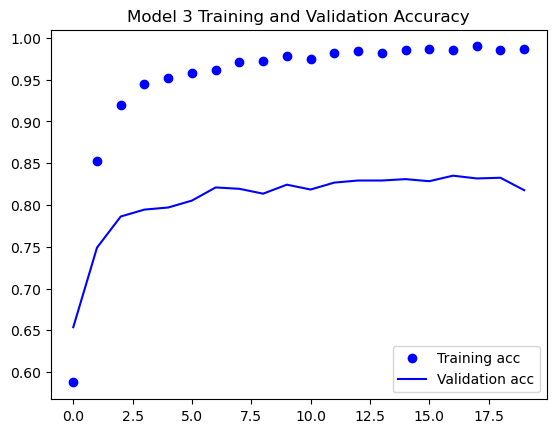

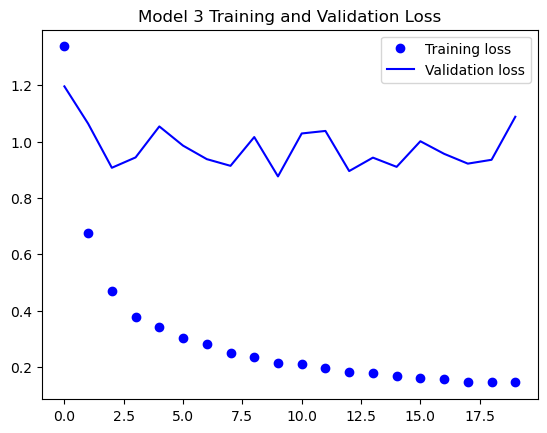

In [40]:
#Plot the model's train accuracy, validation accuracy, train loss, and validation loss by each epoch using the model's
    #histoire variable
model_3_acc = model_3_histoire.history['accuracy']
model_3_val_acc = model_3_histoire.history['val_accuracy']
model_3_loss = model_3_histoire.history['loss']
model_3_val_loss = model_3_histoire.history['val_loss']
model_3_epochs = range(len(model_3_acc))

plt.plot(model_3_epochs, model_3_acc, 'bo', label = 'Training acc')
plt.plot(model_3_epochs, model_3_val_acc, 'b', label = 'Validation acc')
plt.title('Model 3 Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(model_3_epochs, model_3_loss, 'bo', label = 'Training loss')
plt.plot(model_3_epochs, model_3_val_loss, 'b', label = 'Validation loss')
plt.title('Model 3 Training and Validation Loss')
plt.legend()
plt.show();



#### Confusion Matrix

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
2022-12-12 00:09:24.434201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


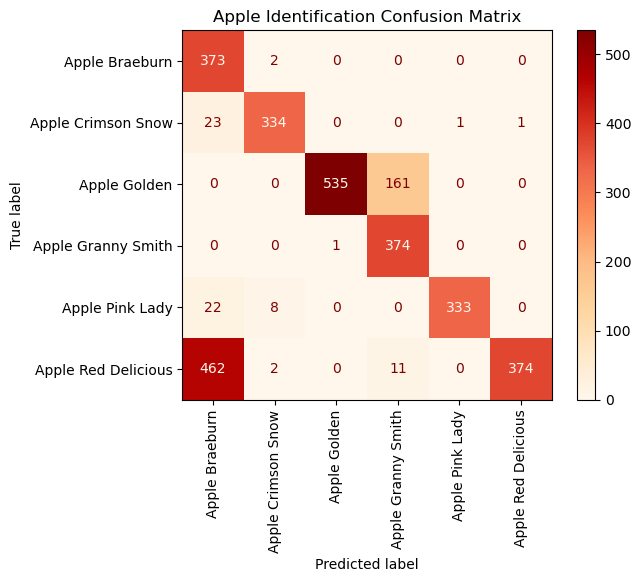

In [41]:
classifier = estimator(model_3, class_names)
plot_confusion_matrix(estimator = classifier, 
                      X = model_3_test_images, 
                      y_true = np.argmax(model_3_test_labels, axis = -1),
                      display_labels = class_names,
                      xticks_rotation = 'vertical',
                     cmap='OrRd');
plt.title('Apple Identification Confusion Matrix')
plt.show()

#### Third Model - w/ No Augmented Images

To compare with the previous model, we will utilize the same parameters with a Sequential model except we will now demonstrate a model utilizing the original data set with no augmented images.

In [42]:
#Similar to the previous models, use an ImageDataGenerator for each file type, the train, test, and validation images
    #In this model we will also add a 'fill mode' parameter which will be set to 'nearest'
no_aug_model_3_train_datagen = ImageDataGenerator(rescale = 1./255,
                                          fill_mode = 'nearest')
no_aug_model_3_test_datagen = ImageDataGenerator(rescale = 1./255)
no_aug_model_3_val_datagen = ImageDataGenerator(rescale = 1./255)

#Create a generator for each of the train, test, and validation files
    #We will utilize the data set with augmented images, set the path to the aug_ applicable path
    #Set the batch size to the number of images in the applicable folder
    #The color mode of these images are RGB
    #The class mode is categorical as there are >2 apple types being reviewed
    #Set the random seed consistently to 42
no_aug_model_3_train_generator = no_aug_model_3_train_datagen.flow_from_directory(no_aug_train_path,
                                                                                  target_size = model_3_image_size,
                                                                                  batch_size = 7841,
                                                                                  color_mode = 'rgb',
                                                                                  class_mode = 'categorical',
                                                                                  seed = 42)

no_aug_model_3_test_generator = no_aug_model_3_test_datagen.flow_from_directory(no_aug_test_path,
                                                                                target_size = model_3_image_size,
                                                                                batch_size = 3017,
                                                                                color_mode = 'rgb',
                                                                                class_mode = 'categorical',
                                                                                seed = 42)

no_aug_model_3_val_generator = no_aug_model_3_val_datagen.flow_from_directory(no_aug_val_path,
                                                                              target_size = model_3_image_size,
                                                                              batch_size = 1207,
                                                                              color_mode = 'rgb',
                                                                              class_mode = 'categorical',
                                                                              seed = 42)

#Create the data sets for each of the train, test and validation images
no_aug_model_3_train_images, no_aug_model_3_train_labels = next(no_aug_model_3_train_generator)
no_aug_model_3_test_images, no_aug_model_3_test_labels = next(no_aug_model_3_test_generator)
no_aug_model_3_val_images, no_aug_model_3_val_labels = next(no_aug_model_3_val_generator)

Found 2563 images belonging to 6 classes.
Found 954 images belonging to 6 classes.
Found 285 images belonging to 6 classes.


In [43]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Instantiate a Sequential model
    #To start add a Convolutional2D layer set to an activation of 'reul' and an input shape consistent with the image
        #size
    #Then add a MaxPooling layer set to a padding of 'same'
    #Add a dropout layer set to 20%
    #Following a dropout layer always add a flatten layer
    #Add one Dense layer, set the layer to 48 and a last Dense layer set to 6 as there are 6 apple varieties
no_aug_model_3 = models.Sequential()
no_aug_model_3.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
no_aug_model_3.add(layers.MaxPooling2D((2,2), padding = 'same'))
no_aug_model_3.add(layers.Dropout(0.2))
no_aug_model_3.add(layers.Flatten())
no_aug_model_3.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
no_aug_model_3.add(layers.Dense(6, activation='softmax', kernel_regularizer = reg))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate=0.0002)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of le-8, and a patience of 10
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 1e-8, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, utilize the categorical crossentropy for loss as this is not a
    #binary model, and utilize 'accuracy' as the target metric
no_aug_model_3.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

#Creat a new _histoire variable containing the fit model
    #To begin, we will utilize 70 epochs and a batch size of 120
no_aug_model_3_histoire = no_aug_model_3.fit(no_aug_model_3_train_images,
                                       no_aug_model_3_train_labels,
                                       callbacks = [es],
                                       epochs = 70,
                                       batch_size = 120,
                                       validation_data = (no_aug_model_3_val_images, no_aug_model_3_val_labels))

Epoch 1/70
 1/22 [>.............................] - ETA: 5s - loss: 2.3866 - accuracy: 0.1333

2022-12-12 00:09:26.999927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 46ms/step - loss: 1.4975 - accuracy: 0.6567 - val_loss: 0.7868 - val_accuracy: 0.9263
Epoch 2/70
 1/22 [>.............................] - ETA: 0s - loss: 0.8838 - accuracy: 0.8917

2022-12-12 00:09:28.021096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 38ms/step - loss: 0.5868 - accuracy: 0.9618 - val_loss: 0.3811 - val_accuracy: 0.9965
Epoch 3/70
22/22 [==============================] - 1s 37ms/step - loss: 0.3285 - accuracy: 0.9914 - val_loss: 0.2612 - val_accuracy: 1.0000
Epoch 4/70
22/22 [==============================] - 1s 38ms/step - loss: 0.2467 - accuracy: 0.9961 - val_loss: 0.2173 - val_accuracy: 1.0000
Epoch 5/70
22/22 [==============================] - 1s 37ms/step - loss: 0.2089 - accuracy: 0.9984 - val_loss: 0.1942 - val_accuracy: 1.0000
Epoch 6/70
22/22 [==============================] - 1s 37ms/step - loss: 0.1924 - accuracy: 0.9973 - val_loss: 0.1847 - val_accuracy: 1.0000
Epoch 7/70
22/22 [==============================] - 1s 37ms/step - loss: 0.1771 - accuracy: 0.9996 - val_loss: 0.1716 - val_accuracy: 1.0000
Epoch 8/70
22/22 [==============================] - 1s 39ms/step - loss: 0.1661 - accuracy: 0.9996 - val_loss: 0.1594 - val_accuracy: 1.0000
Epoch 9/70
22/22 [======

Epoch 60/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0358 - accuracy: 1.0000 - val_loss: 0.0352 - val_accuracy: 1.0000
Epoch 61/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 1.0000
Epoch 62/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.0358 - val_accuracy: 1.0000
Epoch 63/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.0322 - val_accuracy: 1.0000
Epoch 64/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 65/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 1.0000
Epoch 66/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 

In [44]:
#View the model's total number of parameters using the .summary() function
no_aug_model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 18)        504       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 18)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 49, 49, 18)        0         
                                                                 
 flatten_2 (Flatten)         (None, 43218)             0         
                                                                 
 dense_13 (Dense)            (None, 48)                2074512   
                                                                 
 dense_14 (Dense)            (None, 6)                 294       
                                                      

In [45]:
#Create variables for the train and test results to print the accuracy and loss scores
no_aug_model_3_results_train = no_aug_model_3.evaluate(no_aug_model_3_train_images, no_aug_model_3_train_labels)
no_aug_model_3_results_test = no_aug_model_3.evaluate(no_aug_model_3_test_images, no_aug_model_3_test_labels)

print(f'Model 3 w/ No Augmentation Train Results: {no_aug_model_3_results_train}')
print(f'Model 3 w/ No Augmentation Test Results: {no_aug_model_3_results_test}')

30/30 [==============================] - 0s 14ms/step - loss: 0.0868 - accuracy: 0.9748
Model 3 w/ No Augmentation Train Results: [0.02795940451323986, 1.0]
Model 3 w/ No Augmentation Test Results: [0.0868181362748146, 0.9748428463935852]


As with the previous models, this model is essentially the same as the previous third model except it is now utilizing the non-augmented images data set. For the sake of consistency, we will refer to the below saved scores as the scores to be referenced throughout the notebook. As seen, the third model which utilizes the data set with no augmented images performed better than the model with the augmented images with a train accuracy and loss of ~100% and 0.03, respectively, and a test accuracy and loss of ~96% and 0.1, respectively.

In [46]:
# # no_aug_model_3.save('./Supplement Notebooks/Saved Models/Model 3 - No Data Aug', save_format='tf')
no_aug_model_3_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 3 - No Data Aug')
no_aug_model_3_saved.evaluate(no_aug_model_3_train_images, no_aug_model_3_train_labels)
no_aug_model_3_saved.evaluate(no_aug_model_3_test_images, no_aug_model_3_test_labels)

 9/81 [==>...........................] - ETA: 1s - loss: 0.0350 - accuracy: 1.0000

2022-12-12 00:10:26.846844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 14ms/step - loss: 0.1211 - accuracy: 0.9623


[0.121090367436409, 0.9622642397880554]

### Final Results

Considering each model that was ran, the ‘final model’ for the stakeholder will be third model that utilizes the data set with augmented images. The scores achieved with this model were a train accuracy and loss of ~99% and 0.2, respectively, and a test accuracy and loss of ~80% and 2, respectively. Although the third model with the same parameters performed better (a train accuracy and loss of ~100% and 0.03, respectively, and a test accuracy and loss of ~96% and 0.1, respectively), a model with augmented images will better serve the stakeholder. The model with augmented images are more realistic to apples on a conveyor belt with certain images turned flipped, at different shapes and hues, etc.

## Recommendation:

With the above analysis, it is recommended that the stakeholder, Mott’s, utilizes the final, third model, which took into account the augmented image data set. Based the model, it appears as though Mott’s utilizing this model, will correctly identify ~80% of apples which fall into the six varieties of apples – Braeburn, Crimson Snow, Golden Delicious, Granny Smith, Pink Lady, and Red Delicious. As previously mentioned, Mott’s current categorization system heavily relies on farmers to correctly organize deliveries (which is not always the case) with workers visually ‘spot checking’ the apples that are passed through production plants. Although the final model is not perfectly accurate, a model with an about 80% accuracy will effectively aid Mott’s with streamlining the current categorization process. By implementing this model, the process will require less work force to visually inspect apples and ultimately save Mott’s considerably on labor costs.

### Next Steps: 
Further criteria and analyses could yield additional insights to further inform the stakeholder by:
- **Utilizing additional images and collect real-world data.** The stakeholder should consider utilizing a data set in addition, particularly images that are representative of apples in a Mott’s factory. Images including those of apples on a conveyor belt, or images with several apples in a single image would allow for the model to continuously train on these images and ultimately produce higher training and testing accuracy scores. 
- **Adding additional apple varieties.** Another factor the stakeholder should consider is including data of other apple varieties. As previously mentioned, Mott’s processes upwards of hundreds of thousands of apples a day. These apples are not limited to the six varieties analyzed in this model. Therefor it would be beneficial with additional time for the stakeholder to consider utilizing data of other apple types. 
- **Considering other apple characteristics.** Lastly, the stakeholder should consider other apple characteristics to analyze with the model. At present, the model is taking into account only certain visual characteristics of each apple type. Other characteristics, particularly feel/texture are very telling of an apple’s variety through its skin. By factoring in these other attributes the model would only further train and become more accurate when review unseen data.